# Capstone Procject : Price Comparision Application.
## Name : Abhi Shah
# Student ID : 100902154

## Used to predict the name of Vegetable or fruit after uploading the iamge using Deep learning Neural network Algorithm (MobileNet).
  

In [6]:
#https://drive.google.com/file/d/1QuNiemdQM5uovroIALQdkvEdmwU8ZWxR/view?usp=drive_link
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
import pandas as pd
import random

## Read the file and load the image.

In [7]:
INIT_LR = 1e-4
EPOCHS = 60
BS = 32

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:

#/content/gdrive/MyDrive/data.zip
zip_path = '/content/gdrive/MyDrive/data_1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_images_new_folder_1')




# add images in data as well as add label.

In [10]:
images_train = []
labels_train = []

images_test = []
labels_test = []

folder_path = '/content/extracted_images_new_folder_1/data_1/train'

test_folder = '/content/extracted_images_new_folder_1/data_1/test'

for dirfolder in os.listdir(folder_path):
    dirfolderpath = os.path.join(folder_path, dirfolder)
    for image_file in os.listdir(dirfolderpath):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
          image_path = os.path.join(dirfolderpath, image_file)
          image = load_img(image_path, target_size=(224, 224))
          image = img_to_array(image)

          image_data = preprocess_input(image)
          images_train.append(image_data)
          labels_train.append(dirfolder)


for dirfolder in os.listdir(test_folder):
    dirfolderpath = os.path.join(test_folder, dirfolder)
    for image_file in os.listdir(dirfolderpath):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
          image_path = os.path.join(dirfolderpath, image_file)
          image = load_img(image_path, target_size=(224, 224))
          image = img_to_array(image)

          image_data = preprocess_input(image)
          images_test.append(image_data)
          labels_test.append(dirfolder)



## check the data is loaded correctly in RGB format.

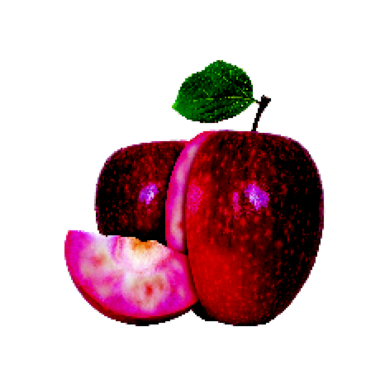

apple


In [11]:
plt.imshow(images_train[100][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(labels_train[100])

## Now check for test folder data is loaded correctly with label.

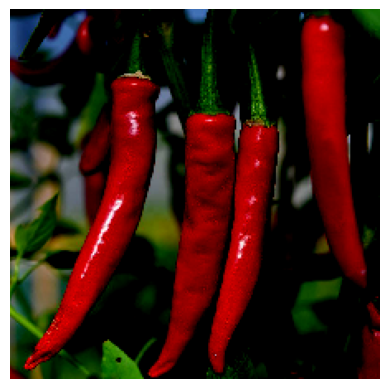

chilli pepper


In [12]:
plt.imshow(images_test[125][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(labels_test[125])

## convert the data to float.

In [13]:
images_train = np.array(images_train, dtype="float32")
images_test = np.array(images_test, dtype="float32")

lb = LabelEncoder()
labels = lb.fit_transform(labels_train)
labels_train = to_categorical(labels)

labels = lb.fit_transform(labels_test)
labels_test = to_categorical(labels)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

total_categories = len(labels_train[0])

# Now it is required to randomize the data.

In [14]:
data = []

data_test = []

for index,l in enumerate(images_train):
    obj = {}
    obj['image'] = images_train[index]
    obj['label'] = labels_train[index]
    data.append(obj)


for index,l in enumerate(images_test):
    obj = {}
    obj['image'] = images_test[index]
    obj['label'] = labels_test[index]
    data_test.append(obj)


# Check for the data object,

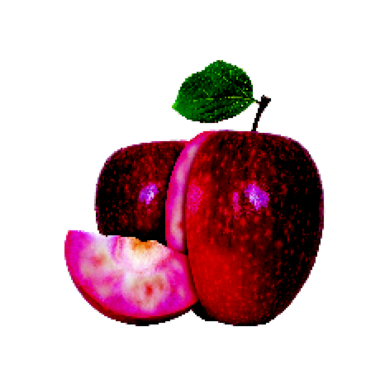

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
plt.imshow(data[100]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data[100]['label'])

# random mize the list for both test and train data.

In [16]:
random.shuffle(data)
random.shuffle(data_test)

# verify that randow is done correctly within list.

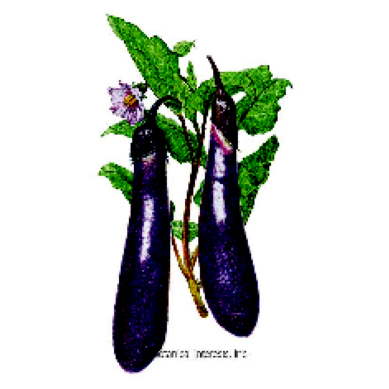

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
plt.imshow(data[103]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data[103]['label'])

## Verify for the test data.

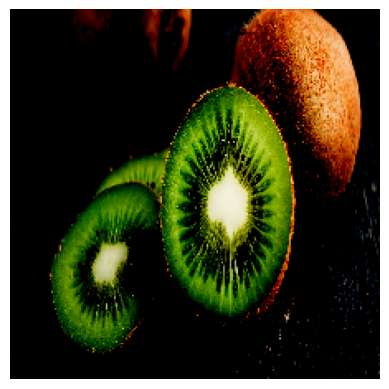

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [18]:
plt.imshow(data_test[72]['image'][:,:])
plt.axis('off')  # Optional: Remove axes and ticks
plt.show()
print(data_test[72]['label'])

# Image Generator.

In [19]:

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
	)


baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

head = baseModel.output
head = AveragePooling2D(pool_size=(4, 4))(head)
head = Flatten(name="flatten")(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(total_categories, activation="softmax")(head)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=head)



for layer in baseModel.layers:
	layer.trainable = False

# compile the model.
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()


9406464/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
     

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 nv2D)                                                                                            
                                                                                                  
 block_4_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_4_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_4_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_4_depthwise_BN[0][0]']   
                                                                                                  
 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 
                                                                                                  
 block_4_project_BN (BatchNorma  (None, 28, 28, 32)  128         ['block_4_project[0][0]']        
 lization)

# Now train the model.

In [20]:
print("[INFO] train the model")

selected_property_image = [item['image'] for item in data]

selected_property_label = [item['label'] for item in data]

selected_property_image = np.array(selected_property_image, dtype="float32")

selected_property_label = np.array(selected_property_label)


#print(selected_property_image.shape)

#print(selected_property_label.shape)

model.fit(
	aug.flow(selected_property_image, selected_property_label, batch_size=BS),
	steps_per_epoch=len(selected_property_image) // BS,
	validation_data=(selected_property_image, selected_property_label),
	validation_steps=len(selected_property_label) // BS,
	epochs=EPOCHS)


[INFO] train the model
Epoch 1/60
53/53 [==============================] - 186s 3s/step - loss: 3.4848 - accuracy: 0.0550 - val_loss: 2.9066 - val_accuracy: 0.1516
Epoch 2/60
53/53 [==============================] - 241s 5s/step - loss: 3.1394 - accuracy: 0.0793 - val_loss: 2.8058 - val_accuracy: 0.2352
Epoch 3/60
53/53 [==============================] - 180s 3s/step - loss: 3.0044 - accuracy: 0.1018 - val_loss: 2.7147 - val_accuracy: 0.3304
Epoch 4/60
53/53 [==============================] - 181s 3s/step - loss: 2.8641 - accuracy: 0.1432 - val_loss: 2.6021 - val_accuracy: 0.3984
Epoch 5/60
53/53 [==============================] - 183s 3s/step - loss: 2.7778 - accuracy: 0.1852 - val_loss: 2.4706 - val_accuracy: 0.4698
Epoch 6/60
53/53 [==============================] - 178s 3s/step - loss: 2.6716 - accuracy: 0.2089 - val_loss: 2.3067 - val_accuracy: 0.5372
Epoch 7/60
53/53 [==============================] - 175s 3s/step - loss: 2.5538 - accuracy: 0.2544 - val_loss: 2.1449 - val_accurac

## predict the model to classify among 21 entities of vegetables or fruits.

In [24]:
selected_property_image_test = [item['image'] for item in data_test]

selected_property_label_test = [item['label'] for item in data_test]

selected_property_image_test = np.array(selected_property_image_test, dtype="float32")

selected_property_label_test = np.array(selected_property_label_test)

print("evaluation of neural network")
predIdxs = model.predict(selected_property_image_test, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a classification report
print(classification_report(selected_property_label_test.argmax(axis=1), predIdxs,
	target_names=lb.classes_))



evaluation of neural network
7/7 [==============================] - 9s 1s/step
               precision    recall  f1-score   support

        apple       1.00      0.89      0.94         9
       banana       1.00      0.78      0.88         9
     beetroot       0.91      1.00      0.95        10
  bell pepper       0.64      1.00      0.78         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.44      0.62         9
       carrot       0.89      1.00      0.94         8
  cauliflower       1.00      1.00      1.00         9
chilli pepper       1.00      0.67      0.80         9
         corn       1.00      1.00      1.00        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      0.90      0.95        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       0.88      0.88      0.88         8
     jalepeno       0.73      0.89      

In [22]:
model.save("vegetable_fruit_classification.model", save_format="h5")

In [23]:
# Generate pickle file to use this notebook in application.

import sys
import pickle

projectabspathname = os.path.abspath('Capstone_Veg_Fruit_Model.pickle')
print(projectabspathname)
projectname = 'Capstone_Veg_Fruit_Model.ipynb'
projectpickle = open(str(projectabspathname),'wb')
pickle.dump(projectname, projectpickle)
projectpickle.close()

/content/Capstone_Veg_Fruit_Model.pickle
